In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']

vae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

### Read the data

In [5]:
adata_all = sc.read('pancreas.h5ad')

#### Celltype labels of all the datasets should be unique

That's why we merge the celltype label with the study to make sure that there are no duplicates

In [6]:
adata_all.obs['celltype_batch'] = np.char.add(np.array(adata_all.obs['cell_type'], dtype= str),
                                             np.array(adata_all.obs['study'], dtype=str))

In [7]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()

### Integrate reference datasets

In [8]:
sca.dataset.setup_anndata(source_adata, batch_key=condition_key)


INFO     Using batches from adata.obs["study"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [9]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)


In [10]:
vae.train(n_epochs=vae_epochs, frequency=1, early_stopping_kwargs=early_stopping_kwargs)


INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  31%|██████████▍                       | 153/500 [01:34<03:34,  1.61it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  31%|██████████▍                       | 153/500 [01:35<03:35,  1.61it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  63 s. / 500 epochs                                

In [11]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["celltype_batch"] = source_adata.obs['celltype_batch'].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()


... storing 'cell_type' as categorical
... storing 'celltype_batch' as categorical
... storing 'batch' as categorical


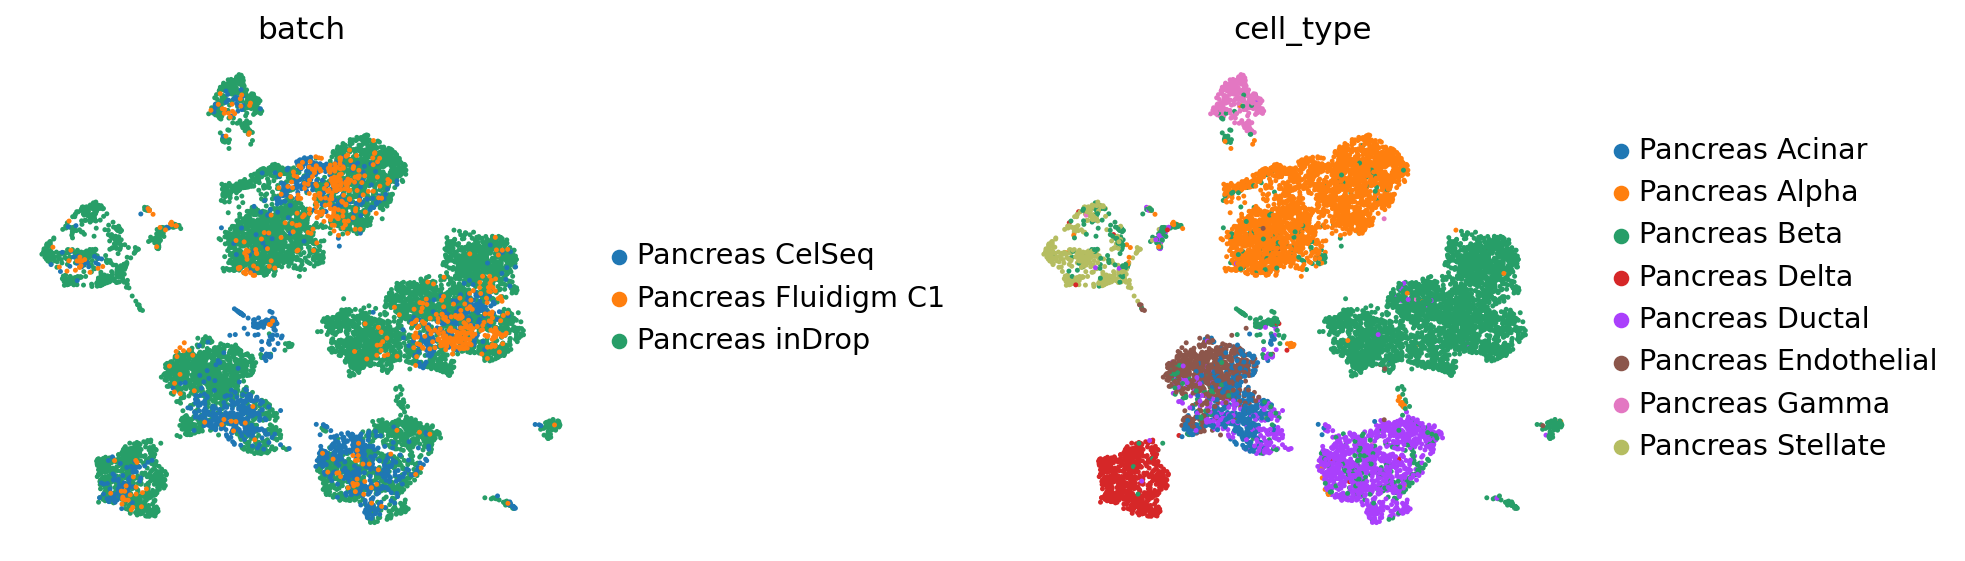

In [12]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6, size = 20
           )


### Construct hierarchy for the reference using scHPL

In [13]:
tree, mp = sca.classifiers.scHPL.learn(data = reference_latent, 
                batch_key = 'batch',
                batch_order = ['Pancreas inDrop', 'Pancreas CelSeq', 'Pancreas Fluidigm C1'],
                cell_type_key='celltype_batch',
                classifier = 'svm',
                dimred = False)

Starting tree:
root
	Pancreas AcinarPancreas inDrop
	Pancreas AlphaPancreas inDrop
	Pancreas BetaPancreas inDrop
	Pancreas DeltaPancreas inDrop
	Pancreas DuctalPancreas inDrop
	Pancreas EndothelialPancreas inDrop
	Pancreas GammaPancreas inDrop
	Pancreas StellatePancreas inDrop

Adding dataset Pancreas CelSeq to the tree
Perfect match:  Pancreas AcinarPancreas CelSeq is now: Pancreas AcinarPancreas inDrop
Perfect match:  Pancreas AlphaPancreas CelSeq is now: Pancreas AlphaPancreas inDrop
Perfect match:  Pancreas DeltaPancreas CelSeq is now: Pancreas DeltaPancreas inDrop
Perfect match:  Pancreas DuctalPancreas CelSeq is now: Pancreas DuctalPancreas inDrop
Perfect match:  Pancreas EndothelialPancreas CelSeq is now: Pancreas EndothelialPancreas inDrop
Perfect match:  Pancreas GammaPancreas CelSeq is now: Pancreas GammaPancreas inDrop

Updated tree:
root
	Pancreas AcinarPancreas inDrop
	Pancreas AlphaPancreas inDrop
	Pancreas BetaPancreas inDrop
		Pancreas BetaPancreas CelSeq
	Pancreas Delt

In [14]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)

### Integrate query dataset into the reference

In [15]:
model = sca.models.SCVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 5387 cells, 1000 vars, 5 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [16]:
model.train(n_epochs=surgery_epochs, frequency=1, early_stopping_kwargs=early_stopping_kwargs, weight_decay=0)


INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  18%|██████▏                            | 89/500 [00:26<02:02,  3.36it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  18%|██████▏                            | 89/500 [00:26<02:03,  3.34it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  16 s. / 500 epochs                                

In [17]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()


WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

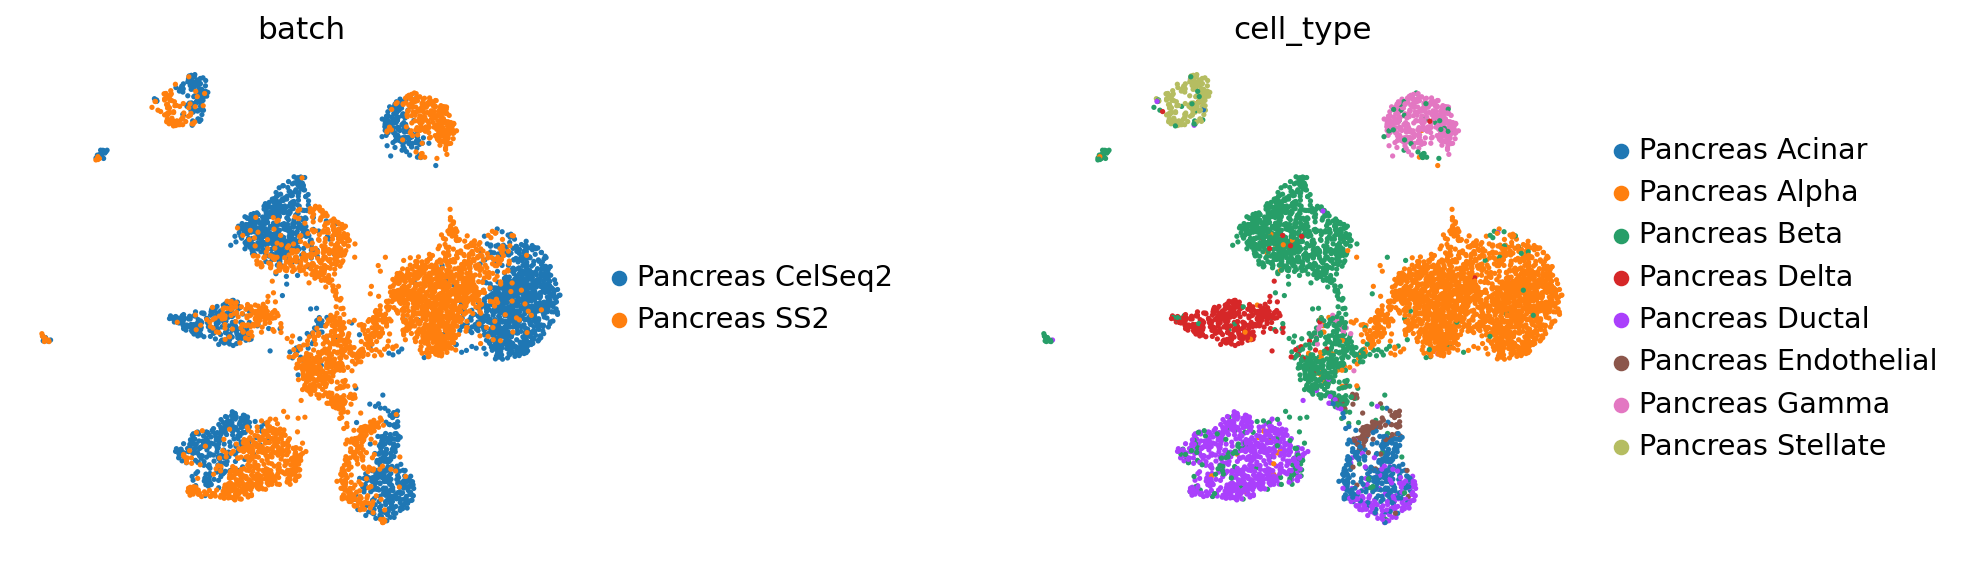

In [18]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)


In [19]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()
full_latent.obs['celltype_batch'] = adata_full.obs['celltype_batch'].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15681 cells, 1000 vars, 5 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


... storing 'cell_type' as categorical
... storing 'batch' as categorical
... storing 'celltype_batch' as categorical


<Figure size 320x320 with 0 Axes>

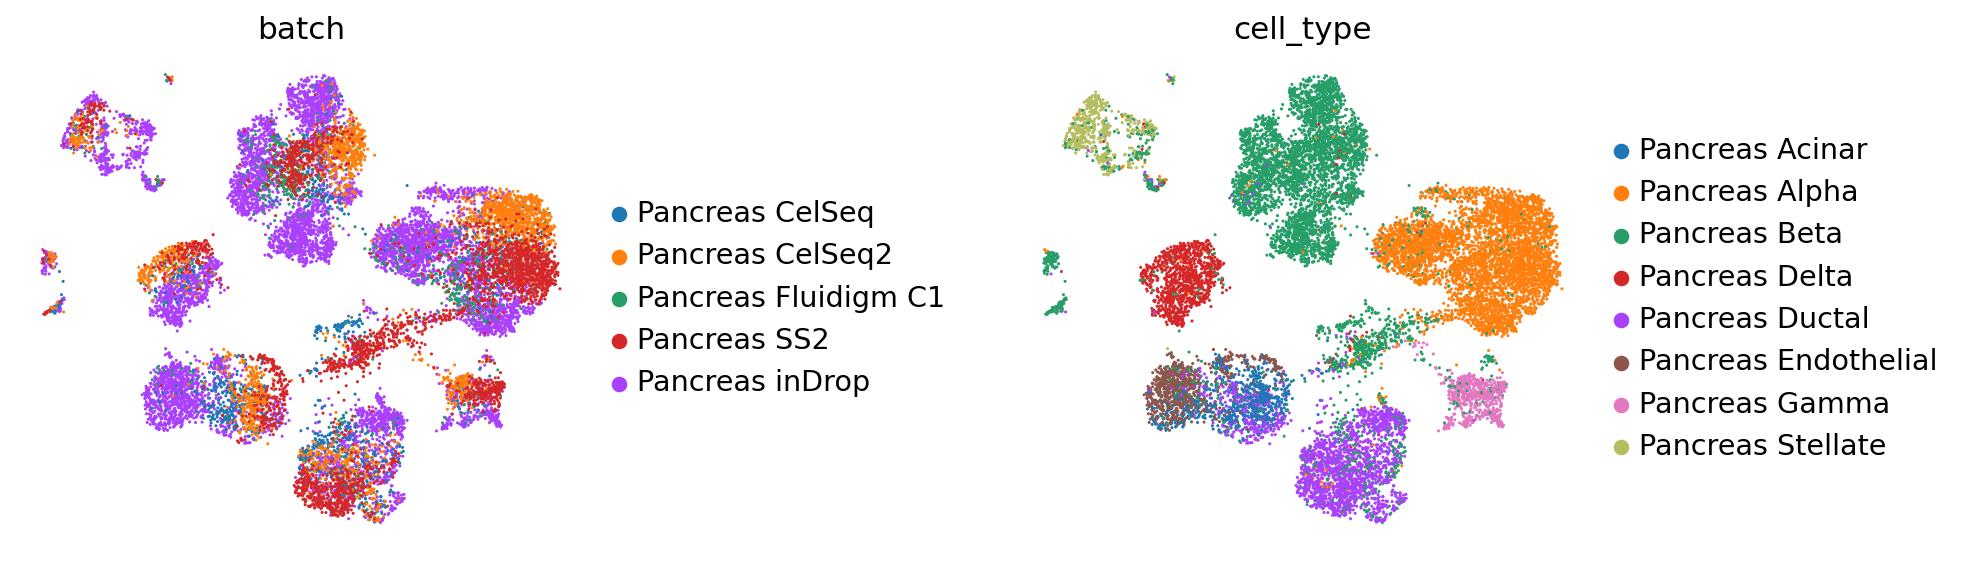

In [20]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)


### Update the learned hierarchy with the query datasets

In [21]:
tree, mp = sca.classifiers.scHPL.learn(data = full_latent, batch_key = 'batch',
                 batch_order = ['Pancreas CelSeq2', 'Pancreas SS2'],
                 batch_added = ['Pancreas CelSeq', 'Pancreas Fluidigm C1', 'Pancreas inDrop'],
                 cell_type_key='celltype_batch',
                 tree = tree, retrain = False,
                classifier = 'svm',
                dimred = False)

Starting tree:
root
	Pancreas AcinarPancreas inDrop
		Pancreas AcinarPancreas Fluidigm C1
	Pancreas AlphaPancreas inDrop
	Pancreas BetaPancreas inDrop
		Pancreas BetaPancreas CelSeq
	Pancreas DeltaPancreas inDrop
	Pancreas DuctalPancreas inDrop
		Pancreas DuctalPancreas Fluidigm C1
	Pancreas EndothelialPancreas inDrop
	Pancreas GammaPancreas inDrop
		Pancreas GammaPancreas Fluidigm C1
	Pancreas StellatePancreas inDrop
		Pancreas StellatePancreas CelSeq

Adding dataset Pancreas CelSeq2 to the tree
Perfect match:  Pancreas AlphaPancreas CelSeq2 is now: Pancreas AlphaPancreas inDrop
Perfect match:  Pancreas BetaPancreas CelSeq2 is now: Pancreas BetaPancreas inDrop
Perfect match:  Pancreas DuctalPancreas CelSeq2 is now: Pancreas DuctalPancreas inDrop
Perfect match:  Pancreas GammaPancreas CelSeq2 is now: Pancreas GammaPancreas inDrop
Perfect match:  Pancreas StellatePancreas CelSeq2 is now: Pancreas StellatePancreas inDrop
Perfect match:  Pancreas AcinarPancreas CelSeq2 is now: Pancreas Ac